# Regression/Classifier of Loan Amount

In [1]:
## Packages to import
from itertools import *
import numpy as np
import pandas as pd
import sys
## Install packages if need be
#!{sys.executable} -m pip install category_encoders
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install xgboost

#Encoders and Imputers
from category_encoders import TargetEncoder, OneHotEncoder, HashingEncoder, BinaryEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

#Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

#Plotting and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn and models
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score

from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

## Load Data

In [2]:
# ## Load Data
df = pd.read_csv('Finalized_Dataset_1.csv')

# Sector Data
df1 = pd.read_csv('lda_sector.csv')
df1 = df1.rename(columns={"Unnamed: 0": "Filename"})

# Set target variable loan amount
df['loan_amount'] = df['loan_amount'].multiply(10**(-6))
dg = df.loan_amount
dF = df.merge(df1, how='inner', on='Filename')
dF = dF.drop(columns=['Filename','loan_amount'])
print(dF.head())
print(dg.head())

   Year    Country                Region        Elec        GDPpC        Lit  \
0  1990     poland        eastern europe  100.000000  6170.249054  98.742737   
1  1990  indonesia  asia (ex. near east)   63.788554  3082.082407  81.519852   
2  1990       peru   latin amer. & carib   60.893643  3361.406815  84.556222   
3  1990    algeria       northern africa   97.575848  6916.495704  54.882416   
4  1990      india  asia (ex. near east)   41.239654  1201.668486  48.797584   

    Gini  Stability  sector  
0  39.30   0.599995       6  
1  31.20  -2.387409       0  
2  41.38  -1.388897       1  
3  39.50  -1.896126       6  
4  42.88  -1.321757       0  
0     18.0
1    329.0
2    350.0
3    110.0
4     25.0
Name: loan_amount, dtype: float64


### See datatypes and any missing values

In [3]:
## General Information about data
print(df.info())
print(df.dtypes)
print(df.Region.unique())
print('The number of countries is ',len(df.Country.unique()))
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Filename     2875 non-null   object 
 1   Year         2875 non-null   int64  
 2   loan_amount  2875 non-null   float64
 3   Country      2875 non-null   object 
 4   Region       2875 non-null   object 
 5   Elec         2875 non-null   float64
 6   GDPpC        2875 non-null   float64
 7   Lit          2875 non-null   float64
 8   Gini         2875 non-null   float64
 9   Stability    2875 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 224.7+ KB
None
Filename        object
Year             int64
loan_amount    float64
Country         object
Region          object
Elec           float64
GDPpC          float64
Lit            float64
Gini           float64
Stability      float64
dtype: object
['eastern europe' 'asia (ex. near east)' 'latin amer. & carib'
 'northern af

### Split intro train/val/test sets

In [4]:
### Split train and test and validation (Compare some models with validation)
X_train,X_test,y_train,y_test = train_test_split(dF,dg,test_size=0.20,random_state=42)
X_tt,X_val,y_tt,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=32)

### Check for correlation between variables

In [5]:
print(pd.concat([X_tt,y_tt],axis=1).corr())

                 Year      Elec     GDPpC       Lit      Gini  Stability  \
Year         1.000000  0.329297  0.429665  0.329492  0.098246  -0.004853   
Elec         0.329297  1.000000  0.419890  0.681424  0.140314   0.331034   
GDPpC        0.429665  0.419890  1.000000  0.360034  0.141640   0.353025   
Lit          0.329492  0.681424  0.360034  1.000000  0.125785   0.231533   
Gini         0.098246  0.140314  0.141640  0.125785  1.000000   0.081540   
Stability   -0.004853  0.331034  0.353025  0.231533  0.081540   1.000000   
sector      -0.053902 -0.004031 -0.086452 -0.025620 -0.103394  -0.016735   
loan_amount  0.147518  0.068159  0.088663  0.042748 -0.029669  -0.087525   

               sector  loan_amount  
Year        -0.053902     0.147518  
Elec        -0.004031     0.068159  
GDPpC       -0.086452     0.088663  
Lit         -0.025620     0.042748  
Gini        -0.103394    -0.029669  
Stability   -0.016735    -0.087525  
sector       1.000000     0.034015  
loan_amount  0.0340

### Check Distributions of Data

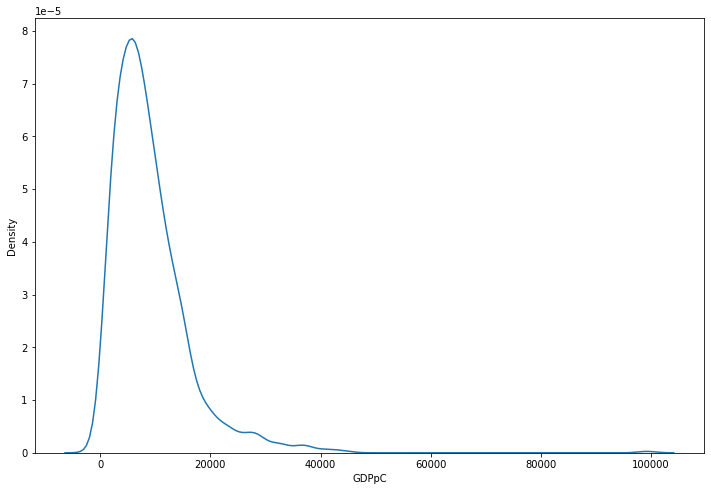

array([[<AxesSubplot:xlabel='Year', ylabel='Year'>,
        <AxesSubplot:xlabel='Elec', ylabel='Year'>,
        <AxesSubplot:xlabel='GDPpC', ylabel='Year'>,
        <AxesSubplot:xlabel='Lit', ylabel='Year'>,
        <AxesSubplot:xlabel='Gini', ylabel='Year'>,
        <AxesSubplot:xlabel='Stability', ylabel='Year'>,
        <AxesSubplot:xlabel='sector', ylabel='Year'>],
       [<AxesSubplot:xlabel='Year', ylabel='Elec'>,
        <AxesSubplot:xlabel='Elec', ylabel='Elec'>,
        <AxesSubplot:xlabel='GDPpC', ylabel='Elec'>,
        <AxesSubplot:xlabel='Lit', ylabel='Elec'>,
        <AxesSubplot:xlabel='Gini', ylabel='Elec'>,
        <AxesSubplot:xlabel='Stability', ylabel='Elec'>,
        <AxesSubplot:xlabel='sector', ylabel='Elec'>],
       [<AxesSubplot:xlabel='Year', ylabel='GDPpC'>,
        <AxesSubplot:xlabel='Elec', ylabel='GDPpC'>,
        <AxesSubplot:xlabel='GDPpC', ylabel='GDPpC'>,
        <AxesSubplot:xlabel='Lit', ylabel='GDPpC'>,
        <AxesSubplot:xlabel='Gini', ylabel='

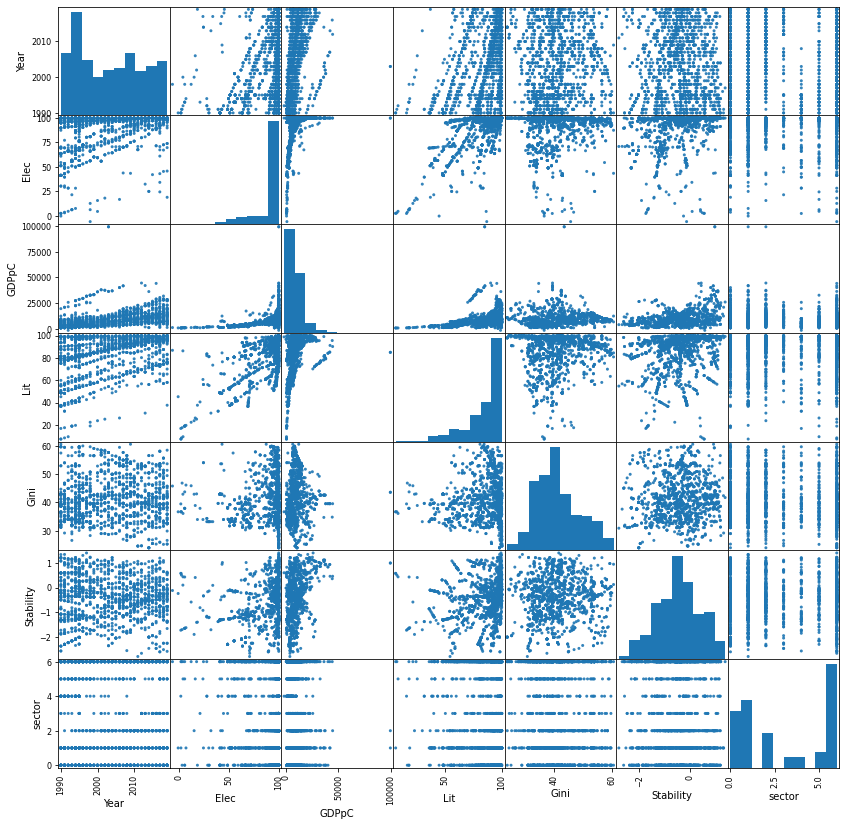

In [6]:
## Plotting to get an idea of distributions in each class (using Kernel Density Estimator)
numeric_kde = 'GDPpC' #Elec, GDPpC, Lit, Gini, Stability,

fig = plt.figure(figsize=(12, 8))
#gs = fig.add_gridspec(3,1)
#gs.update(hspace= -0.55)

sns.kdeplot(x=numeric_kde, data = X_tt)
plt.show()
  


### Scatter plots
#plt.figure(figsize=(12,12))
#plt.scatter(X_tt.age,X_tt.income)

from pandas.plotting import scatter_matrix
#print(y_tt.head())
scatter_matrix(X_tt,figsize=(14,14),alpha=.9)

### Trim or Drop Outliers

In [7]:
# ## Trimming Outliers
# def trim_outliers(X_tt_imp):
#     X = X_tt_imp.copy()
#     X['income'] = X['income'].clip(upper=X_tt_imp.income.quantile(.95),lower=X_tt_imp.income.quantile(.05))
#     X['age'] = X['age'].clip(upper=X_tt_imp.age.quantile(.95),lower=X_tt_imp.age.quantile(.05))
#     X['brand_awareness_index'] = X['brand_awareness_index'].clip(upper=X_tt_imp.brand_awareness_index.quantile(.95))
#     X['customer_loyalty_index'] = X['customer_loyalty_index'].clip(upper=X_tt_imp.customer_loyalty_index.quantile(.95),lower=-X_tt_imp.customer_loyalty_index.quantile(.95))
#     return X

## Dropping outliers (more than 3 stddevs from mean)
def drop_outliers(X_tt,y_tt):
    X = X_tt.copy()
    y = y_tt.copy()
    Xc = pd.concat([X,y],axis=1)
    Xc = Xc.drop(Xc[(Xc['loan_amount'] > Xc.loan_amount.quantile(.997)) | (Xc['loan_amount'] < Xc.loan_amount.quantile(.003)) | 
                    (Xc['Elec'] > Xc.Elec.quantile(.997)) | (Xc['Elec'] < Xc.Elec.quantile(.003)) | 
                    (Xc['GDPpC'] > Xc.GDPpC.quantile(.997)) | (Xc['GDPpC'] < Xc.GDPpC.quantile(.003)) | 
                    (Xc['Gini'] > Xc.Gini.quantile(.997)) | (Xc['Gini'] < Xc.Gini.quantile(.003)) | 
                    (Xc['Lit'] > Xc.Lit.quantile(.997)) | (Xc['Lit'] < Xc.Lit.quantile(.003)) | 
                    (Xc['Stability'] > Xc.Stability.quantile(.997)) | (Xc['Stability'] < Xc.Stability.quantile(.003))].index)
    Xd = Xc.drop(columns=['loan_amount'])
    yd = Xc.loan_amount
    return Xd,yd


## Training data with outliers removed
X_tt_d,y_tt_d = drop_outliers(X_tt,y_tt)
print(X_tt_d.shape)
print(y_tt_d.shape)

(1790, 9)
(1790,)


### Encoders

In [8]:
## ENCODERS
def hashing_encoding(df_feature):
    '''For state data'''
    df = df_feature.copy()
    he=HashingEncoder(n_components=8)
    return he.fit_transform(df)


def binary_encoding(df_feature):
    df = df_feature.copy()
    be= BinaryEncoder(handle_missing='return_nan',return_df=True)
    return be.fit_transform(df)

def ordinal_encoding(df_feature):
    df = df_feature.copy()
    oe = OrdinalEncoder(handle_missing='return_nan',return_df=True)
    ddf = oe.fit_transform(df)
    ddf.columns = [df_feature.name+'_enc']
    return ddf

def one_hot_encoding(df_feature):
    df = df_feature.copy()
    ohe = OneHotEncoder(handle_unknown='return_nan',return_df=True,use_cat_names=True)
    return ohe.fit_transform(df)



def encode(X):
    df = X.copy()
    enc = [df,ordinal_encoding(df['Region'])]
    df1 = pd.concat(enc,axis=1)
    X_enc = df1.drop(columns=['Region','Country','Year'])
    return X_enc

In [9]:
X_tt_e = encode(X_tt_d)
print(X_tt_e.columns)
X_tt_e.dtypes

Index(['Elec', 'GDPpC', 'Lit', 'Gini', 'Stability', 'sector', 'Region_enc'], dtype='object')


Elec          float64
GDPpC         float64
Lit           float64
Gini          float64
Stability     float64
sector          int64
Region_enc    float64
dtype: object

### Scaling

In [10]:
## MinMaxScaling not necessary for tree based methods as it is monotonic transformation
def scaling(X):    
    scaler = MinMaxScaler() 
    X1 = X.copy()
    X1['Elec'] = scaler.fit_transform(np.array(X1['Elec']).reshape(-1, 1))
    X1['GDPpC'] = scaler.fit_transform(np.array(X1['GDPpC']).reshape(-1, 1))
    X1['Lit'] = scaler.fit_transform(np.array(X1['Lit']).reshape(-1, 1))
    X1['Gini'] = scaler.fit_transform(np.array(X1['Gini']).reshape(-1, 1))
    X1['Stability'] = scaler.fit_transform(np.array(X1['Stability']).reshape(-1, 1))
    return X1

In [11]:
#X_tt_scale = scaling(X_tt_e)
#print(X_tt_scale.describe())

### Discretize Variables

In [12]:
def discretize(df,col,num_bins):
    df[col+'_bin']=pd.qcut(x = df[col].rank(method='first'),q=num_bins,labels = False)
    return

def bin_data(df):
    discretize(df,'Elec',num_bins=10)
    discretize(df,'GDPpC',num_bins=10)
    discretize(df,'Lit',num_bins=10)
    discretize(df,'Gini',num_bins=10)
    discretize(df,'Stability',num_bins=10)
    return df.drop(columns=['Elec','GDPpC','Lit','Gini','Stability'])

In [13]:
## Discretize continous values
X_tt_disc = bin_data(X_tt_e)
print(X_tt_disc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1790 entries, 2112 to 671
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sector         1790 non-null   int64  
 1   Region_enc     1790 non-null   float64
 2   Elec_bin       1790 non-null   int64  
 3   GDPpC_bin      1790 non-null   int64  
 4   Lit_bin        1790 non-null   int64  
 5   Gini_bin       1790 non-null   int64  
 6   Stability_bin  1790 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 111.9 KB
None


In [14]:
X_tt_disc.head()

,sector,Region_enc,Elec_bin,GDPpC_bin,Lit_bin,Gini_bin,Stability_bin
2112,2,1.0,2,5,2,3,3
1619,6,2.0,6,5,1,0,4
2232,6,3.0,2,3,1,5,2
2861,0,1.0,3,6,3,8,3
2343,1,4.0,2,7,4,8,5


### Normalize Distr

In [15]:
def log_normalize(df,col):
    df[col] = df[col].apply(lambda x: np.log(x+1))
    return

### Boxplot to get idea of outliers
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x=df[col]) #see how skew it is afterwards

# Prepare Validation Set

In [16]:
def transform(X_train1,X_test1):
    X_train = X_train1.copy()
    X_test = X_test1.copy()
    X_test['train'] = 0
    X_train['train'] = 1
    comb = pd.concat([X_train,X_test])
    comb_enc = encode(comb)
    #comb_scale = scaling(comb_enc)
    comb_disc = bin_data(comb_enc)
    comb_disc = comb_disc.apply(pd.to_numeric)
    X_train_enc = comb_disc[comb_disc['train'] == 1].drop(columns=['train'])
    X_test_enc = comb_disc[comb_disc['train'] == 0].drop(columns=['train'])
    return X_train_enc, X_test_enc

#X,y = drop_outliers(X_tt,y_tt)
X_tt_enc,X_val_enc = transform(X_tt_d,X_val)
print(X_tt_enc.info())
print(X_tt_enc.head())
print(y_tt_d.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1790 entries, 2112 to 671
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sector         1790 non-null   int64  
 1   Region_enc     1790 non-null   float64
 2   Elec_bin       1790 non-null   int64  
 3   GDPpC_bin      1790 non-null   int64  
 4   Lit_bin        1790 non-null   int64  
 5   Gini_bin       1790 non-null   int64  
 6   Stability_bin  1790 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 111.9 KB
None
      sector  Region_enc  Elec_bin  GDPpC_bin  Lit_bin  Gini_bin  \
2112       2         1.0         2          4        2         3   
1619       6         2.0         6          5        1         0   
2232       6         3.0         2          3        1         5   
2861       0         1.0         3          5        3         8   
2343       1         4.0         2          7        4         8   

      Stability_bin  
2112    

# XGBRegressor

## Hyperparameter Tuning for Regression

In [17]:
def model_hyperparam_tune(max_dep,gam,alph,lamb):
    xgb_model = XGBRegressor(n_estimators = 50, max_depth=max_dep, min_child_weight=5, gamma=gam, eta=0.1, subsample=.75, colsample_bytree=0.8,reg_alpha=alph,reg_lambda=lamb)
    xgb_model.fit(X_tt_enc,y_tt_d,eval_metric='mape')
    y_pred = xgb_model.predict(X_val_enc)
    y_tt_pred = xgb_model.predict(X_tt_enc)
    rmse1 = np.sqrt(mean_squared_error(y_val, y_pred))
    mae1 = mean_absolute_error(y_val,y_pred)
    mape1 = mean_absolute_percentage_error(y_val,y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val,y_pred)
    mape = mean_absolute_percentage_error(y_val,y_pred)
    print("MAE %f and RMSE %f and MAPE %f" % (mae,rmse,mape))
    return y_pred,y_tt_pred,mape

max_dep = (5,8)
gam = (.05,.1,.2)
alph = (.05,.1,.2)
lamb = (.05,.1,.2)
M = 1000
Z = ()
for z in product(max_dep,gam,alph,lamb):
    print(z)
    y_pred,mape= model_hyperparam_tune(*z)
    if mape < M:
        M = mape
        Z = z
        
print('Best hyperparameters are\n')
print(Z)
print(M)
## MAPE (200% errror)

(5, 0.05, 0.05, 0.05)
MAE 92.402338 and RMSE 177.467974 and MAPE 2.098836
(5, 0.05, 0.05, 0.1)
MAE 92.689031 and RMSE 177.460180 and MAPE 2.105744
(5, 0.05, 0.05, 0.2)
MAE 92.796208 and RMSE 177.384090 and MAPE 2.128906
(5, 0.05, 0.1, 0.05)
MAE 92.402434 and RMSE 177.468067 and MAPE 2.098850
(5, 0.05, 0.1, 0.1)
MAE 92.689181 and RMSE 177.460291 and MAPE 2.105759
(5, 0.05, 0.1, 0.2)
MAE 92.796272 and RMSE 177.384184 and MAPE 2.128915
(5, 0.05, 0.2, 0.05)
MAE 92.402474 and RMSE 177.468034 and MAPE 2.098876
(5, 0.05, 0.2, 0.1)
MAE 93.306965 and RMSE 177.951365 and MAPE 2.132212
(5, 0.05, 0.2, 0.2)
MAE 92.796394 and RMSE 177.384366 and MAPE 2.128932
(5, 0.1, 0.05, 0.05)
MAE 92.402338 and RMSE 177.467974 and MAPE 2.098836
(5, 0.1, 0.05, 0.1)
MAE 92.689031 and RMSE 177.460180 and MAPE 2.105744
(5, 0.1, 0.05, 0.2)
MAE 92.796208 and RMSE 177.384090 and MAPE 2.128906
(5, 0.1, 0.1, 0.05)
MAE 92.402434 and RMSE 177.468067 and MAPE 2.098850
(5, 0.1, 0.1, 0.1)
MAE 92.689181 and RMSE 177.460291 and 

## Train XGBRegreesor on whole training set

In [18]:
X_train_enc,X_test_enc = transform(X_train,X_test)

In [19]:
#Using 
d,g,a,l = Z
xgb_model = XGBRegressor(n_estimators = 200, max_depth=d, min_child_weight=5, gamma=g, eta=0.1, subsample=.75, colsample_bytree=0.8,reg_alpha=a,reg_lambda=l)
xgb_model.fit(X_train_enc,y_train,eval_metric='rmse')
y_pred = xgb_model.predict(X_test_enc)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test,y_pred)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("MAE %f and RMSE %f and MAPE %f" % (mae,rmse,mape))
print(y_test.head())
print(y_pred[:5])


MAE 90.628828 and RMSE 150.332518 and MAPE 2.349589
729      58.00000
2434    200.00000
1289    161.10000
1740    383.83778
937      16.40000
Name: loan_amount, dtype: float64
[212.20198   73.564804 257.12836   50.30973  166.3391  ]


## Feature Importance

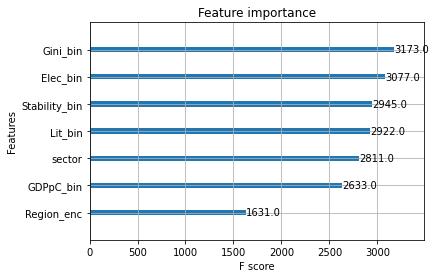

In [20]:
### Feature Importance
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [9, 9]
plt.show()


# XGBClassifier

## Discretize Loan Amounts

In [21]:
#dF,dG = drop_outliers(df,dg)
dg_disc=pd.qcut(x = dg.rank(method='first'),q=10,labels = False)
X_train_disc,X_test_disc,y_train_disc,y_test_disc = train_test_split(dF,dg_disc,test_size=0.20,random_state=42)
X_tt_disc,X_val_disc,y_tt_disc,y_val_disc = train_test_split(X_train_disc,y_train_disc,test_size=0.20,random_state=32)
# ## Discretize loan amounts
# y_tt_disc=pd.qcut(x = y_tt_d.rank(method='first'),q=10,labels = False)
# y_val_disc=pd.qcut(x = y_val.rank(method='first'),q=10,labels = False)
X_tt_disc_d,y_tt_disc_d = drop_outliers(X_tt_disc,y_tt_disc)

In [22]:
def transform(X_train1,X_test1):
    X_train = X_train1.copy()
    X_test = X_test1.copy()
    X_test['train'] = 0
    X_train['train'] = 1
    comb = pd.concat([X_train,X_test])
    comb_enc = encode(comb)
    comb_disc = bin_data(comb_enc)
    comb_disc = comb_disc.apply(pd.to_numeric)
    X_train_enc = comb_disc[comb_disc['train'] == 1].drop(columns=['train'])
    X_test_enc = comb_disc[comb_disc['train'] == 0].drop(columns=['train'])
    return X_train_enc, X_test_enc

X_tt_disc_enc,X_val_disc_enc = transform(X_tt_disc_d,X_val_disc)
print(y_val_disc.shape,X_val_disc_enc.shape)

(460,) (460, 7)


In [23]:
## F1 score
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

## Baseline for Classifier

In [24]:
print(dg_disc.value_counts())
y_base = [1]*len(y_tt_disc_d)
sc=f1_score(y_tt_disc_d, y_base,average ='micro')
print("Baseline F1 Score %f" % sc)

4    288
7    288
0    288
2    288
9    288
1    287
8    287
6    287
3    287
5    287
Name: loan_amount, dtype: int64
Baseline F1 Score 0.096613


## Hyperparameter Tuning for Classification

In [25]:
def model_hyperparam_tune1(max_dep,alph,lamb):
    xgb_model = XGBClassifier(n_estimators = 200, objective='multi:softprob',max_depth=max_dep, min_child_weight=5, gamma=0, learning_rate=0.1, subsample=.75, colsample_bytree=0.8,reg_alpha=alph,reg_lambda=lamb)
    xgb_model.fit(X_tt_disc_enc,y_tt_disc_d,eval_metric=f1_eval)
    y_pred = xgb_model.predict(X_val_disc_enc)
    a = f1_score(y_val_disc, y_pred,average ='micro')
    print("F1 Score %f" % a)
    return y_pred,a

max_dep = (5,8)
alph = (.05,.1,.2)
lamb = (.05,.1,.2)
M = 0
Z = ()
for z in product(max_dep,alph,lamb):
    print(z)
    y_pred,a = model_hyperparam_tune1(*z)
    if a > M:
        M = a
        Z = z
        
print('Best hyperparameters are\n')
print(Z)
print(M)


(5, 0.05, 0.05)
[11:49:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.221739
(5, 0.05, 0.1)
[11:49:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.210870
(5, 0.05, 0.2)
[11:49:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.215217
(5, 0.1, 0.05)
[11:49:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.213043
(5, 0.1, 0.1)
[11:49:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.215217
(5, 0.1, 0.2)
[11:49:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.215217
(5, 0.2, 0.05)
[11:49:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.215217
(5, 0.2, 0.1)
[11:49:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.221739
(5, 0.2, 0.2)
[11:49:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.217391
(8, 0.05, 0.05)
[11:49:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.213043
(8, 0.05, 0.1)
[11:50:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.213043
(8, 0.05, 0.2)
[11:50:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.213043
(8, 0.1, 0.05)
[11:50:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.223913
(8, 0.1, 0.1)
[11:50:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.215217
(8, 0.1, 0.2)


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score 0.208696
(8, 0.2, 0.05)
[11:50:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.219565
(8, 0.2, 0.1)
[11:50:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.217391
(8, 0.2, 0.2)
[11:50:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 Score 0.206522
Best hyperparameters are

(8, 0.1, 0.05)
0.22391304347826088


## Train Classification Model on whole training set

In [26]:
X_train_disc_enc,X_test_disc_enc = transform(X_train_disc,X_test_disc)
#y_train_disc=pd.qcut(x = y_train_disc.rank(method='first'),q=10,labels = False)
#y_test_disc=pd.qcut(x = y_test.rank(method='first'),q=10,labels = False)
print(X_train_disc_enc.shape,y_train_disc.shape)

(2300, 7) (2300,)


In [27]:
#Using 
d,a,l = Z
xgb_class_model = XGBClassifier(n_estimators = 200, max_depth=d, min_child_weight=5, gamma=0, learning_rate=0.1, subsample=.75, colsample_bytree=0.8,reg_alpha=a,reg_lambda=l)
xgb_class_model.fit(X_train_disc_enc,y_train_disc)
y_pred = xgb_class_model.predict(X_test_disc_enc)
a = f1_score(y_test_disc, y_pred,average ='micro')
print("F1 Score %f" % a)
print(y_test_disc.head())
print(y_pred[:10])


/home/kbari/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score 0.281739
729     4
2434    7
1289    7
1740    9
937     1
Name: loan_amount, dtype: int64
[8 5 8 1 1 0 6 4 9 3]


## Feature Importance for Classifier

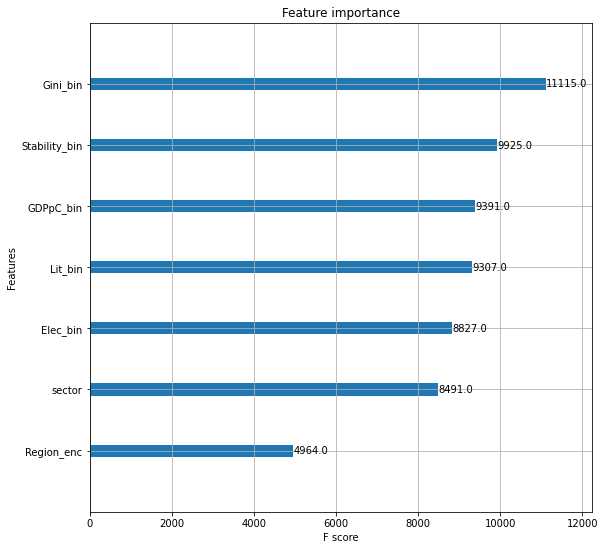

In [28]:
### Feature Importance
xgb.plot_importance(xgb_class_model)
plt.rcParams['figure.figsize'] = [9, 9]
plt.show()


# Decision Tree Regression

## Hyperparameter tuning

In [29]:
# def model_hyperparam_tune_dt(max_dep,gam,alph,lamb):
#     dt_model = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
#                                      max_features=None, max_leaf_nodes=None,
#                                      min_impurity_decrease=0.0, min_impurity_split=None,
#                                      min_samples_leaf=1, min_samples_split=2,
#                                      min_weight_fraction_leaf=0.0, presort='deprecated',
#                                      random_state=None, splitter='best')
#     dt_model.fit(X_tt_enc,y_tt_d,eval_metric='mape')
#     y_pred = dt_model.predict(X_val_enc)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     mae = mean_absolute_error(y_val,y_pred)
#     mape = mean_absolute_percentage_error(y_val,y_pred)
#     print("MAE %f and RMSE %f and MAPE %f" % (mae,rmse,mape))
#     return y_pred,mape

# max_dep = (5,8)
# gam = (.05,.1,.2)
# alph = (.05,.1,.2)
# lamb = (.05,.1,.2)
# M = 1000
# Z = ()
# for z in product(max_dep,gam,alph,lamb):
#     print(z)
#     y_pred,mape= model_hyperparam_tune_dt(*z)
#     if mape < M:
#         M = mape
#         Z = z
        
# print('Best hyperparameters are\n')
# print(Z)
# print(M)

## Imputers

In [30]:
# ## Impute missing data
# def iter_impute(X):
#     impute = IterativeImputer(BayesianRidge())
#     X_imp = pd.DataFrame(impute.fit_transform(X))
#     X_imp.columns = X.columns
#     return X_imp


# # X_tt_imp = iter_impute(X_tt_enc)
# # print(X_tt_imp.shape)
# # print(X_tt_imp.columns)
# # print(X_tt_enc.shape)
# # print(X_tt_enc.columns)

